In [3]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm
from utils import spectral_analysis,make_deviations,make_S_0,make_S_tilde,make_sens_ts
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

In [33]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 2

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities

## 1. Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [5]:
np.random.seed(2022)

In [6]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


## 2. Synthetic demands, fixed power factor 

In [7]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp_synth,dvdq_synth,p_synth,q_synth,v_synth = [pd.read_pickle(f).values for f in files]
sens_synth = make_sens_ts(dvdp_synth,dvdq_synth)
data_synth = make_deviations((p_synth,q_synth,v_synth))
(dx_synth,dv_synth) = data_synth

In [8]:
os.chdir("/home/sam/github/PowerSensitivities.jl/")

## Solve the Matrix recovery problem with different hyperparameters $\lambda$ and $\delta$

### Initialize parameters and known coefficients

In [87]:
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
lambd_values = np.linspace(start=1e-6,stop=1e-1,num=15) #From partially -> highly prioritizing low rank solutions
delta_values = [0,1e-3,1e-2,1e-1,1] # From no disobedience of the precomputed coefficients allowed ->some allowed

#Setup precomputed coefficients
pct_obs = 0.50 #Fix a 35% precomputed coefficient level
O_,S_0 = make_S_0(S_tilde,pct_obs)

#Setup problem
S = cp.Variable(S_0.shape)
prob = mat_sens.mat_rec_problem(S=S,S_0=S_0,dx=dx,dv=dv,lamb=lamb_,o=O_,delta=delta_)


### Sweep over grid of parameters and see effect of parameters on results

In [ ]:
#Save a few sensitivity matrices every 5 iterations to show the effect of the parameters
S_hats = []
results = [] #results for this grid
for i,l in tqdm(enumerate(lambd_values),desc='lambd vals'):
    for d in delta_values:
        #Set hyperparams
        lamb_.value,delta_.value = l,d
        #Solve problem
        prob.solve(verbose=True if i ==0 else False)
        #Store results
        results.append({
            'lambd':l,'delta':d,
            'dv_train_rel_err':mat_sens.calc_rel_err(S.value@dx,dv)*100,
            'dv_test_rel_err':mat_sens.calc_rel_err(S.value@dx_synth,dv_synth)*100,
            'S_rel_err':mat_sens.calc_rel_err(S.value,S_tilde)*100
        })
        if(np.mod(i,5) == 0): #Save a few sensitivity matrices every 5 iterations to show the effect of the parameters
            S_hats.append({
                'S':S.value,
                'lambd':l,
                'delta':d,
                'dv_train_rel_err':mat_sens.calc_rel_err(S.value@dx,dv)*100,
                'dv_test_rel_err':mat_sens.calc_rel_err(S.value@dx_synth,dv_synth)*100,
                'S_rel_err':mat_sens.calc_rel_err(S.value,S_tilde)*100
            })

lambd vals: 0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 12 02:52:01 PM: Your problem has 150152 variables, 2 constraints, and 2 parameters.
(CVXPY) Apr 12 02:52:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 02:52:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 02:52:01 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 12 02:52:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 12 02:52:01 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 12 02:52:01 PM: Applying reduction CvxAttr2Constr
(CVXPY

/home/sam/anaconda3/envs/mohca/lib/python3.9/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-----------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 338255, constraints m: 457345
cones: 	  l: linear vars: 1
	  q: soc vars: 81416, qsize: 2
	  s: psd vars: 375928, ssize: 2
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct
	  nnz(A): 1691852, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 7.50e+02  1.70e+00  7.93e+02 -3.53e+02  1.00e-01  8.60e-01 
   250| 3.01e-02  4.49e-04  1.78e-03 -1.72e-03  1.00e-01  1.91e+02 
   500| 1.76e-02  2.08e-04  1.30e-03 -1.26e-03  1.00e-01  

In [10]:
#Load current results
#import pickle
#with open('results_by_grid.pickle', 'wb') as handle:
#    pickle.dump(results_by_grid, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('S_hats.pickle', 'wb') as handle:
#    pickle.dump(S_hats, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Load old results
# import pickle
# with open('results_by_grid.pickle', 'rb') as handle:
#     results_by_grid = pickle.load(handle)
    
# with open('S_hats.pickle', 'rb') as handle:
#     S_hat = pickle.load(handle)

### Plot the results of the $\tilde{\mathbf{S}}^{\#}$ matrix and errors vs. choice of $\lambda$ and $\delta$

In [37]:
lambd_values = np.logspace(start=-2.5,stop=2,num=10)
delta_values = np.concatenate(([0],np.logspace(start=-4,stop=-1,num=10)))
df_1 = pd.DataFrame.from_dict(results_by_grid[0])
df_2 = pd.DataFrame.from_dict(results_by_grid[1])
results_df = pd.concat([df_1,df_2],ignore_index=True)

<AxesSubplot:xlabel='lambd', ylabel='S_rel_err'>

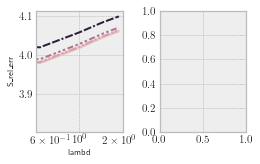

In [50]:
fig,axes = plt.subplots(
    figsize=(3.5,3.5/1.61828),constrained_layout=True,
    nrows=1,ncols=2
)
axes[0].set(xscale="log")
sns.lineplot(
    data=results_df,
    x="lambd",y="S_rel_err",
    hue="delta",style="delta",
    ax=axes[0],legend=False
)

In [64]:
results_df.iloc[0:30]

,lambd,delta,dv_train_rel_err,dv_test_rel_err,S_rel_err
0,0.003162,0.000000,0.029512,6.004114,3.997609
1,0.010000,0.000000,0.058596,6.043783,3.881835
2,0.031623,0.000000,0.102131,6.121700,3.823147
3,0.100000,0.000000,0.171118,6.228415,3.819738
4,0.316228,0.000000,0.273731,6.363197,3.858627
5,1.000000,0.000000,0.389154,6.485463,3.924083
6,3.162278,0.000000,0.532294,6.588227,3.980255
7,10.000000,0.000000,0.728692,6.692141,4.019188
8,31.622777,0.000000,0.972110,6.819057,4.045408
9,100.000000,0.000000,1.300408,7.037755,4.061586


## Solve the Matrix recovery problem with different levels of precomputed local coefficients

In [14]:
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
pct_obs_ = [0.1,0.2,0.3,0.4,0.5,0.75] #Different levels of sensitivities already known to the utility
results = []

In [163]:
#imp.reload(mat_sens)
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    S_tilde = make_S_tilde(svp[0],svq[0])
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat.value,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:37:13 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:37:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:37:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:37:13 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:37:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:37:13 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:37:13 PM: Applying reduction CvxAttr2Constr
(CVXPY

1it [03:19, 199.81s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:40:33 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:40:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:40:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:40:33 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:40:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:40:33 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:40:33 PM: Applying reduction CvxAttr2Constr
(CVXPY

2it [06:45, 203.17s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:43:59 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:43:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:43:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:43:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:43:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:43:59 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:43:59 PM: Applying reduction CvxAttr2Constr
(CVXPY

3it [10:15, 206.41s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:47:29 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:47:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:47:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:47:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:47:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:47:29 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:47:29 PM: Applying reduction CvxAttr2Constr
(CVXPY

4it [13:37, 204.47s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:50:51 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:50:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:50:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:50:51 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:50:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:50:51 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:50:51 PM: Applying reduction CvxAttr2Constr
(CVXPY

5it [16:28, 192.70s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:53:42 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:53:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:53:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:53:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:53:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:53:42 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:53:42 PM: Applying reduction CvxAttr2Constr
(CVXPY

6it [19:54, 199.14s/it]


In [166]:
mat_sens.calc_rel_err(S_hat.value,S_tilde)*100

1.012055777146652

Text(0.5, 1.0, '75% Observable Sensitivty Matrix (IEEE 123-bus)')

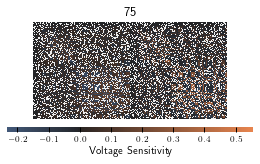

In [164]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

/tmp/ipykernel_935133/194154597.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .85, 1])


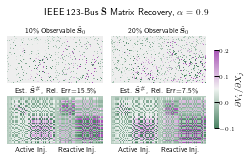

In [356]:
#Subplots
fig,axes = plt.subplots(nrows=2,ncols=2, 
                        figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True, sharey=True)

#Colorbar axis and cmap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cbar_ax = fig.add_axes([.85, .2, .02, .5])
cbar_ax.tick_params(labelsize=6,pad=0.5)
cbar_ax.get_yaxis().labelpad = -1
#cbar_ax.set_label(r"$\partial V_i \big/ \partial X_j$",pad=-1)
cbar_kws = {
    'label':r"$\partial V_i \big/ \partial X_j$",
    'fraction':0.05,
    'shrink':15,
    'pad':-10}


#First recovered matrix
pct_obs = results[1]['pct_obs']
rel_err = results[1]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
#Include colorbar on first heatmap
axes[0,0] = sns.heatmap(np.asarray(S_0),ax=axes[0,0],
                        cmap=cmap,cbar=True,vmin=-0.1,vmax=0.2,
                        cbar_ax=cbar_ax,cbar_kws=cbar_kws,
                        square=True,xticklabels=False,yticklabels=False,
                        mask=(np.asarray(S_0)==0),
                       )
                        
axes[0,0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,0] = sns.heatmap(results[1]['S_hat'],ax=axes[1,0],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)

axes[1,0].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,0].set_xlabel(r"\ \ \ Active Inj. \quad Reactive Inj.",fontsize=7)

#Second recovered matrix
pct_obs = results[2]['pct_obs']
rel_err = results[2]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
axes[0,1] = sns.heatmap(np.asarray(S_0),mask=(np.asarray(S_0)==0),ax=axes[0,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[0,1].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,1] = sns.heatmap(results[2]['S_hat'],ax=axes[1,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[1,1].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,1].set_xlabel(r"\ \ \ Active Inj. \quad  Reactive Inj.",fontsize=7)

#Figure-level formatting
plt.suptitle(r"IEEE 123-Bus $\tilde{\mathbf{S}}$ Matrix Recovery, $\alpha=0.9$",fontsize=9)
fig.tight_layout(rect=[0, 0, .85, 1])
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/IEE123_recovery_multi_lamb.125_delta.006.png",dpi=400)

### Compute the relative error time series (S matrix and voltage perturbations) for each observability level

In [172]:
import utils
for S_result in results:
    pct_obs = S_result["pct_obs"]
    S_hat = S_result["S_hat"]
    v_rel_err,  S_rel_err = [],[]
    for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
        hat_dv_t = S_hat@dx_t
        S_tilde = make_S_tilde(svp[t],svq[t])
        S_rel_err.append(mat_sens.calc_rel_err(S_hat,S_tilde)*100)
        v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
    S_result["S_rel_err"] = S_rel_err
    S_result["v_rel_err"] = v_rel_err

### Plot the relative error time series

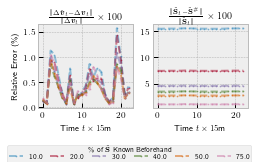

In [310]:
fig,axes = plt.subplots(ncols=2,figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True,sharey=False)
for S_result in results:
    pct_obs = S_result['pct_obs']
    if(pct_obs==0.01):
        continue
    v_rel_err,S_rel_err = S_result['v_rel_err'],S_result['S_rel_err']
    #Voltage relative error
    axes[0].plot(v_rel_err,'--o',label=str(pct_obs*100),alpha=0.5,markersize=0.8)
    #Sensitivity Matrix Relative Error
    axes[1].plot(S_rel_err,'--o',#label=str(pct_obs*100),
                 alpha=0.5,markersize=0.8)
    
#Voltage timeseries plot formatting
axes[0].set_title(r"$\frac{\| \Delta \hat{\boldsymbol{v}}_t - \Delta \boldsymbol{v}_t\|}{\| \Delta \boldsymbol{v}_t \|} \times 100$")
axes[0].set_xlabel(r"Time $t \times 15$m")
axes[0].set_ylabel("Relative Error (\%)")

#S matrix plot formatting
axes[1].set_title(r" $\frac{ \| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}^{\#} \|}{\| \tilde{\mathbf{S}}_t \|} \times 100 $")
axes[1].set_xlabel(r"Time $t \times 15$m")

#Legend
fig.legend(fancybox=True,
           ncol=6,borderpad=0.25,labelspacing=1e-3,columnspacing=1.25,
           loc='lower center',borderaxespad=0.01,
           title=r"\% of $\tilde{\mathbf{S}}$ Known Beforehand",
           fontsize=7,title_fontsize=7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/rel_errs_ieee123.png",dpi=400)

## Plot the Full Matrix

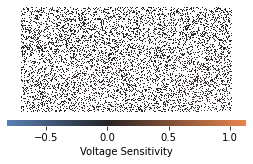

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

## 3. Synthetic demands, varying power factor

In [487]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [517]:
os.chdir("/home/sam/github/PowerSensitivities.jl/py/")
import matrix_sensitivities as mat_sens
imp.reload(mat_sens)

<module 'matrix_sensitivities' from '/home/sam/github/PowerSensitivities.jl/py/matrix_sensitivities.py'>

In [518]:
#imp.reload(mat_sens)
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
dx_,dv_ = cp.Parameter(dx.shape[0]),cp.Parameter(dv.shape[0])
pct_obs_ = [0.5,0.75] #Different levels of sensitivities already known to the utility
results = []
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    dv_.value,dx_.value= dv_t,dx_t #Set the voltage and power data parameters
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx_,dv_,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat_series,
        'S_0':S_0,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 10 05:23:16 PM: Your problem has 150152 variables, 2 constraints, and 824 parameters.
(CVXPY) Apr 10 05:23:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 05:23:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 05:23:16 PM: Compiling problem (target solver=DIFFCP).
(CVXPY) Apr 10 05:23:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> DIFFCP
(CVXPY) Apr 10 05:23:16 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 10 05:23:16 PM: Applying reduction CvxAttr2Const

1it [04:04, 244.04s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 10 05:27:20 PM: Your problem has 150152 variables, 2 constraints, and 824 parameters.
(CVXPY) Apr 10 05:27:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 10 05:27:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 10 05:27:20 PM: Compiling problem (target solver=DIFFCP).
(CVXPY) Apr 10 05:27:20 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> DIFFCP
(CVXPY) Apr 10 05:27:20 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 10 05:27:20 PM: Applying reduction CvxAttr2Const

2it [10:01, 300.65s/it]


In [523]:
lamb_.delta = 1e-2
delta_.delta = 1e-2
prob.derivative()

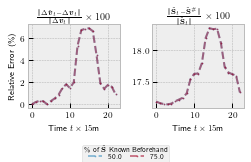

In [519]:
import utils
for S_result in results:
    pct_obs = S_result["pct_obs"]
    S_hat = S_result["S_hat"]
    v_rel_err,  S_rel_err = [],[]
    for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
        hat_dv_t = S_hat@dx_t
        S_tilde = make_S_tilde(svp[t],svq[t])
        S_rel_err.append(mat_sens.calc_rel_err(S_hat,S_tilde)*100)
        v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
    S_result["S_rel_err"] = S_rel_err
    S_result["v_rel_err"] = v_rel_err
    

fig,axes = plt.subplots(ncols=2,figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True,sharey=False)
for S_result in results:
    pct_obs = S_result['pct_obs']
    if(pct_obs==0.01):
        continue
    v_rel_err,S_rel_err = S_result['v_rel_err'],S_result['S_rel_err']
    #Voltage relative error
    axes[0].plot(v_rel_err,'--o',label=str(pct_obs*100),alpha=0.5,markersize=0.8)
    #Sensitivity Matrix Relative Error
    axes[1].plot(S_rel_err,'--o',#label=str(pct_obs*100),
                 alpha=0.5,markersize=0.8)
    
#Voltage timeseries plot formatting
axes[0].set_title(r"$\frac{\| \Delta \hat{\boldsymbol{v}}_t - \Delta \boldsymbol{v}_t\|}{\| \Delta \boldsymbol{v}_t \|} \times 100$")
axes[0].set_xlabel(r"Time $t \times 15$m")
axes[0].set_ylabel("Relative Error (\%)")

#S matrix plot formatting
axes[1].set_title(r" $\frac{ \| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}^{\#} \|}{\| \tilde{\mathbf{S}}_t \|} \times 100 $")
axes[1].set_xlabel(r"Time $t \times 15$m")

#Legend
fig.legend(fancybox=True,
           ncol=6,borderpad=0.25,labelspacing=1e-3,columnspacing=1.25,
           loc='lower center',borderaxespad=0.01,
           title=r"\% of $\tilde{\mathbf{S}}$ Known Beforehand",
           fontsize=7,title_fontsize=7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
#plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/vary_pf_rel_errs_ieee123.png",dpi=400)